# Binary Prediction of Smoker Status using Bio-Signals
Authors: Riccardo Isola, Kevin Cattaneo
<br><br>
Dataset: Smoker Dataset, from Kaggle competition

In [94]:
KAGGLE_COMPETITION_NAME='playground-series-s3e24'

## Preliminary operations

### Imports and libraries setup

In [4]:
# added just for non linux user
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [96]:
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import sklearn
    import xgboost as xgb
    import seaborn as sns
    #import kaggle
except ImportError:
    %pip install numpy matplotlib scikit-learn xgboost ppscore kaggle

### Dataset download

This requires to create an api token from [your kaggle profile](https://www.kaggle.com/settings) and

- put it in the following location: ~/.kaggle/kaggle.json (where ~ is the home folder)

or

- use KAGGLE_USERNAME=abc and KAGGLE_KEY=12341341 environment variables

In [97]:
import os.path
import os
import zipfile

FILES=['train.csv','test.csv']

for file in FILES:
    if os.path.exists(file):
        continue
    !kaggle competitions download -c $KAGGLE_COMPETITION_NAME -w -f $file
    with zipfile.ZipFile(f'{file}.zip') as zip:
        zip.extractall()
    os.remove(f'{file}.zip')

### Other variables

In [98]:
SEED = 5 # Seed for reproducibility

## Data exploration & analysis
**Main Goal**: the objective is to predict based on various medical measurements whether a patient is a smoker person.
<br><br>
Before doing that we will evaluate an analysis on our data, then we will clean them from various impurity, if any, and finally we will construct and train a model from those data.

In [5]:
train_data = pd.read_csv('train.csv')

OSError: [Errno 22] Invalid argument

In [100]:
train_data.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [101]:
print("(n_samples, n_features): " + str(train_data.shape))

(n_samples, n_features): (159256, 24)


In [102]:
train_data.describe().round(2)

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.00,159256.00,159256.00,159256.00,159256.00,159256.00,159256.00,159256.00,159256.00,159256.00,...,159256.00,159256.00,159256.00,159256.00,159256.00,159256.00,159256.00,159256.00,159256.0,159256.00
mean,79627.50,44.31,165.27,67.14,83.00,1.01,1.00,1.02,1.02,122.50,...,55.85,114.61,14.80,1.07,0.89,25.52,26.55,36.22,0.2,0.44
std,45973.39,11.84,8.82,12.59,8.96,0.40,0.39,0.15,0.15,12.73,...,13.96,28.16,1.43,0.35,0.18,9.46,17.75,31.20,0.4,0.50
min,0.00,20.00,135.00,30.00,51.00,0.10,0.10,1.00,1.00,77.00,...,9.00,1.00,4.90,1.00,0.10,6.00,1.00,2.00,0.0,0.00
25%,39813.75,40.00,160.00,60.00,77.00,0.80,0.80,1.00,1.00,114.00,...,45.00,95.00,13.80,1.00,0.80,20.00,16.00,18.00,0.0,0.00
50%,79627.50,40.00,165.00,65.00,83.00,1.00,1.00,1.00,1.00,121.00,...,54.00,114.00,15.00,1.00,0.90,24.00,22.00,27.00,0.0,0.00
75%,119441.25,55.00,170.00,75.00,89.00,1.20,1.20,1.00,1.00,130.00,...,64.00,133.00,15.80,1.00,1.00,29.00,32.00,44.00,0.0,1.00
max,159255.00,85.00,190.00,130.00,127.00,9.90,9.90,2.00,2.00,213.00,...,136.00,1860.00,21.00,6.00,9.90,778.00,2914.00,999.00,1.0,1.00


### Dataset balance of 'smoking'
We check if our data are balanced on 'smoking' column, if not it would influence the model in the next section.

In [103]:
print('How many values for', train_data['smoking'].value_counts())

How many values for smoking
0    89603
1    69653
Name: count, dtype: int64


In [104]:
print('Percentage of', train_data['smoking'].value_counts()/len(train_data))

Percentage of smoking
0    0.562635
1    0.437365
Name: count, dtype: float64


([<matplotlib.patches.Wedge at 0x1af17aacfe0>,
 [Text(-1.078772693555787, -0.21505691255663517, 'non-smoking'),
  Text(1.078772693555787, 0.21505691255663456, 'smoking')],
 [Text(-0.5884214692122474, -0.11730377048543736, '56.26%'),
  Text(0.5884214692122475, 0.11730377048543703, '43.74%')])

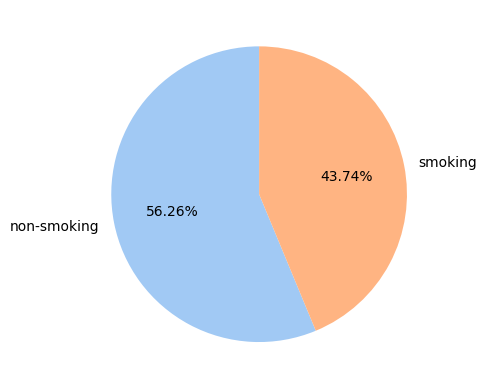

In [105]:
plt.pie(train_data['smoking'].value_counts(), labels=['non-smoking','smoking'], autopct='%1.2f%%', shadow=False, startangle=90, colors=sns.color_palette('pastel'))

Our smoking feature seems balanced.

### Correlation
We analyze the correlation of features with 'smoking' status

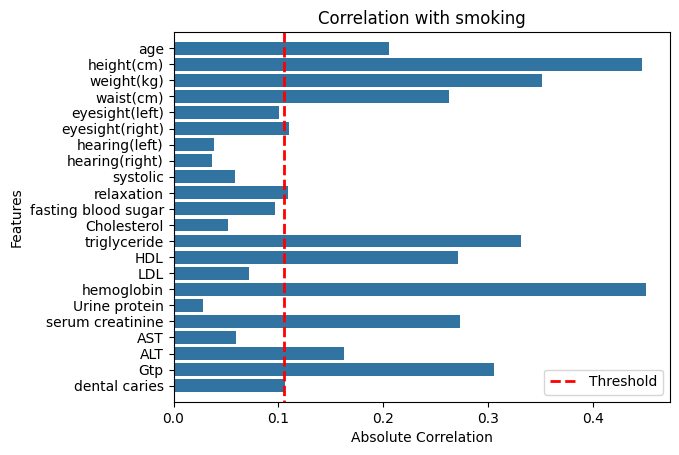

In [106]:
#train_data.corrwith(train_data['smoking'])
#np.abs(train_data.corrwith(train_data['smoking'])) > 0.105 # after looking to the matrix
tmp = train_data.copy()
tmp.drop(columns=['id', 'smoking'], inplace=True)
sns.barplot(y=tmp.corrwith(train_data['smoking']).index, x=np.abs(tmp.corrwith(train_data['smoking']).values))
plt.title("Correlation with smoking")
plt.ylabel("Features")
plt.xlabel("Absolute Correlation")
plt.plot([0.105, 0.105], [-1, len(tmp.columns)], 'r--', lw=2, label='Threshold')
plt.ylim((len(tmp.columns), -1))
plt.legend()

We observe that the most correlated features seems to be the age, height, weight, waist, relaxation blood pressure, the triglyceride, serum creatinine and hemoglobin levels, the gtp indicator and the number of dental caries.
<br><br>
So we decide to plot their correlation, in order to understand better their relation with smoking. We also take note of the least correlated features to be ignored in the model construction: 'LDL', 'AST', 'systolic'               

Text(0.5, 1.0, 'Correlation Matrix')

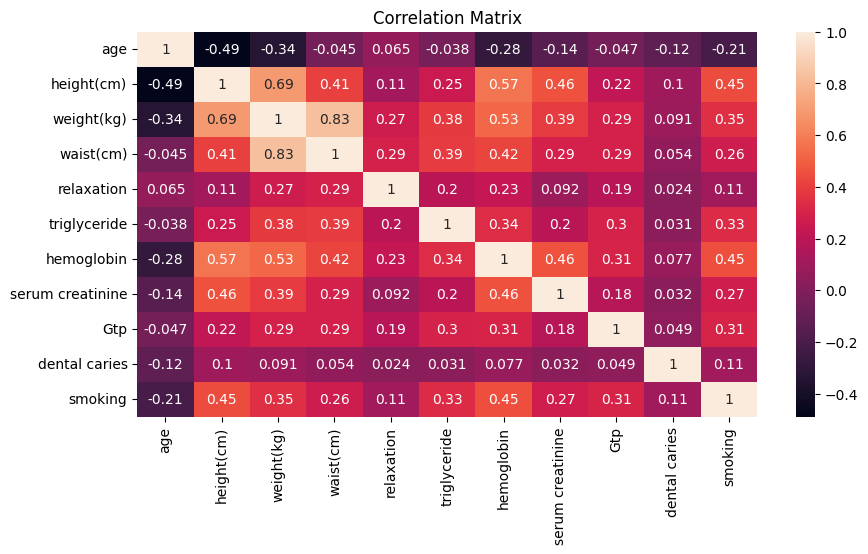

In [107]:
# Plotting the most correlated features with smoking
corr_features = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'relaxation', 'triglyceride', 'hemoglobin', 'serum creatinine', 'Gtp', 'dental caries', 'smoking']
plt.figure(figsize=(10,5))
corr_matrix = train_data[corr_features].corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix")

In [108]:
to_ignore = set(train_data.columns) - set(corr_features)
to_ignore

{'ALT',
 'AST',
 'Cholesterol',
 'HDL',
 'LDL',
 'Urine protein',
 'eyesight(left)',
 'eyesight(right)',
 'fasting blood sugar',
 'hearing(left)',
 'hearing(right)',
 'id',
 'systolic'}

## Data cleaning

We check for NULL or NaN values

In [109]:
train_data.isna().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

Our train dataset has no missing or NaN values.

### Outliers

In [110]:
def outliers_mask(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
    return trueList

def all_outliers_mask(X):
    mask=outliers_mask(X[X.columns[0]])
    for column in X.columns:
        mask&=outliers_mask(X[column])
    return mask

In [111]:
(~outliers_mask(train_data)).sum() # Number of outliers

id                         0
age                      682
height(cm)               463
weight(kg)              2296
waist(cm)                858
eyesight(left)          2324
eyesight(right)         2493
hearing(left)           3818
hearing(right)          3730
systolic                1592
relaxation               981
fasting blood sugar     8160
Cholesterol              430
triglyceride            3087
HDL                     1932
LDL                      495
hemoglobin              1493
Urine protein           8394
serum creatinine        5943
AST                     6337
ALT                     6746
Gtp                     8792
dental caries          31532
smoking                    0
dtype: int64

Text(0.5, 0, 'Normalized values')

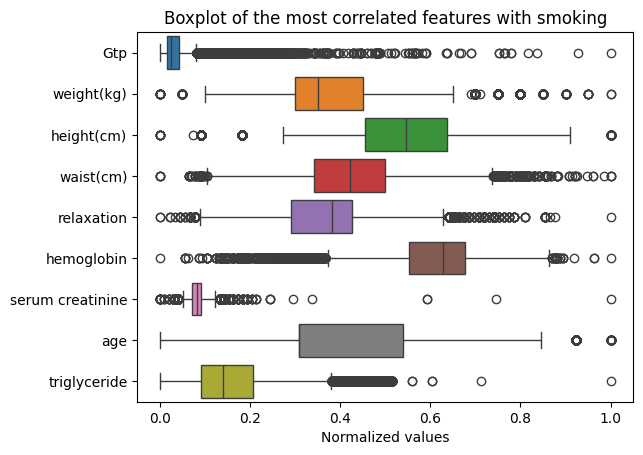

In [112]:
from sklearn.preprocessing import MinMaxScaler
tmp = train_data.copy()
norm = MinMaxScaler(copy=False).fit_transform(tmp)
tmp = pd.DataFrame(norm, columns=tmp.columns)
sns.boxplot(data=tmp[list(set(corr_features)-{'dental caries', 'smoking'})], orient='h')
plt.title("Boxplot of the most correlated features with smoking")
plt.xlabel("Normalized values")


In [113]:
train_data['dental caries'].value_counts()

dental caries
0    127724
1     31532
Name: count, dtype: int64

In [114]:
# Possible categorical features (discrete, finite)
for x in train_data.columns:
    if len(train_data[x].value_counts()) < 10:
        print(x)

hearing(left)
hearing(right)
Urine protein
dental caries
smoking


In [115]:
train_data[['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries', 'smoking']].nunique() # categorical features

hearing(left)     2
hearing(right)    2
Urine protein     6
dental caries     2
smoking           2
dtype: int64

In [116]:
train_data['Urine protein'].value_counts() # verify categories

Urine protein
1    150862
2      5609
3      2228
4       477
5        74
6         6
Name: count, dtype: int64

In [117]:
# Removing outliers
CATEGORICAL_FEATURES = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries'] # without smoking
corr_modified = set(corr_features)
corr_modified -= {*CATEGORICAL_FEATURES, 'smoking'} # since it detects as outliers all categorical features
mask = all_outliers_mask(train_data[list(corr_modified)])
print(train_data.shape)
train_data = train_data[mask]
print(train_data.shape)

(159256, 24)
(137173, 24)


In [118]:
train_data['dental caries'].value_counts() # it has not remove all

dental caries
0    110430
1     26743
Name: count, dtype: int64

## Data visualization

We decide before all to plot the most correlated features. In the first step, we just want to observe how many are them, without any explicit relation with the smoking status.

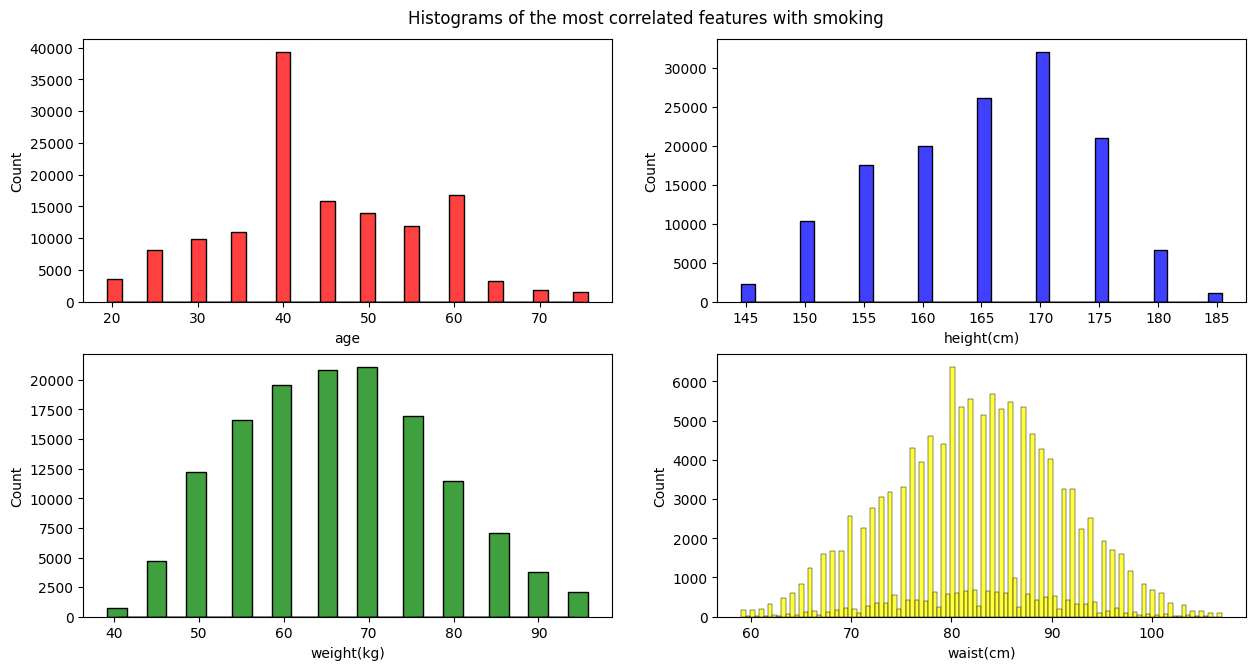

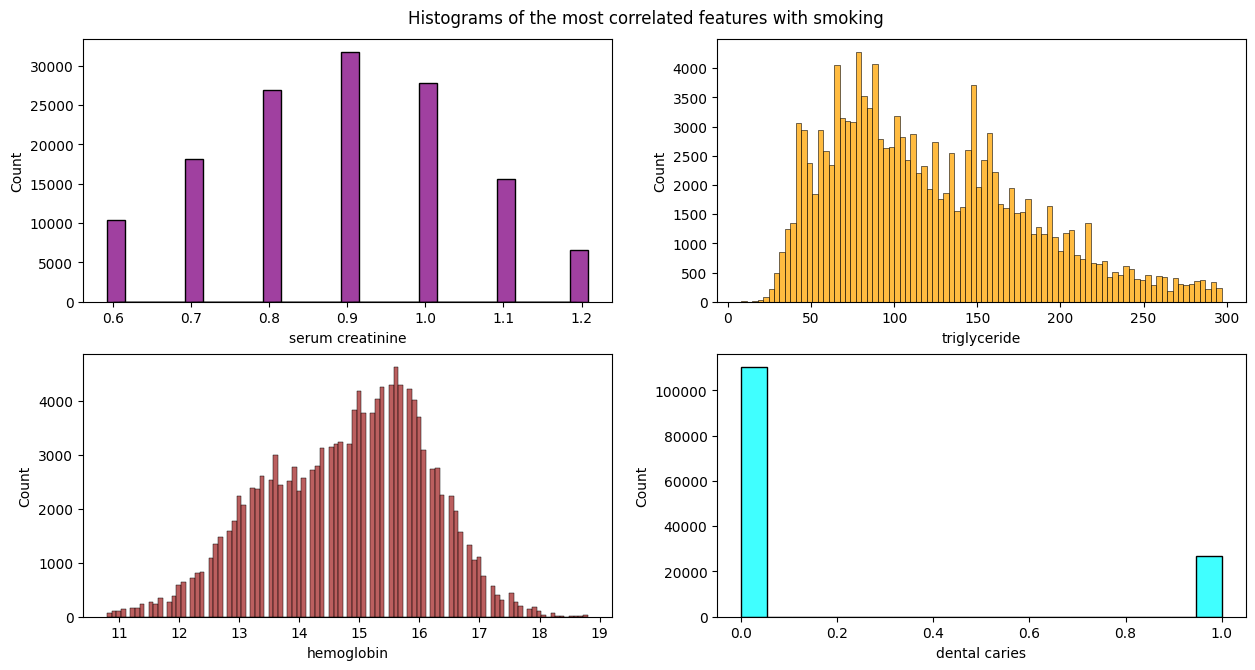

In [119]:
fig, ax = plt.subplots(2, 2, figsize=(15,7.5))
ax = ax.flatten()
sns.histplot(train_data['age'],color='red',ax=ax[0], shrink=3)
sns.histplot(train_data['height(cm)'],color='blue',ax=ax[1], shrink=3)
sns.histplot(train_data['weight(kg)'],color='green',ax=ax[2], shrink=3)
sns.histplot(train_data['waist(cm)'],color='yellow',ax=ax[3])
plt.suptitle("Histograms of the most correlated features with smoking", y=0.92)
plt.show()
fig, ax = plt.subplots(2, 2, figsize=(15,7.5))
ax = ax.flatten()
sns.histplot(train_data['serum creatinine'],color='purple',ax=ax[0], shrink=3)
sns.histplot(train_data['triglyceride'],color='orange',ax=ax[1])
sns.histplot(train_data['hemoglobin'],color='brown',ax=ax[2])
sns.histplot(train_data['dental caries'],color='cyan',ax=ax[3])
plt.suptitle("Histograms of the most correlated features with smoking", y=0.92)
plt.show()

Now we write two informative plots about the age and dental caries, that often influence the smoking status, as our usual knowledge lead to think. 
<br><br>
Then we plot the most correlated features as before, but in relation with smoking.

<Axes: xlabel='dental caries', ylabel='Count'>

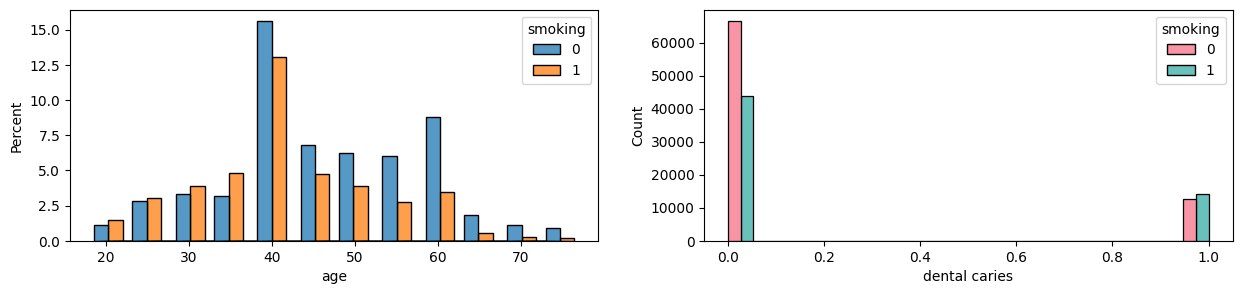

In [120]:
plt.figure(figsize=(15,3))
plt.subplot(121)
sns.histplot(x=train_data['age'], hue=train_data.smoking, stat='percent', multiple='dodge', shrink=6)
plt.subplot(122)
sns.histplot(x=train_data['dental caries'], hue=train_data.smoking, stat='count', multiple='dodge', palette='husl')

It seems that the most percentage of smokers is got by people of age between 30-50 years old. We also see that some people (about 20k) with dental caries are correlated so much with being smoker. 

<Axes: xlabel='height(cm)', ylabel='Count'>

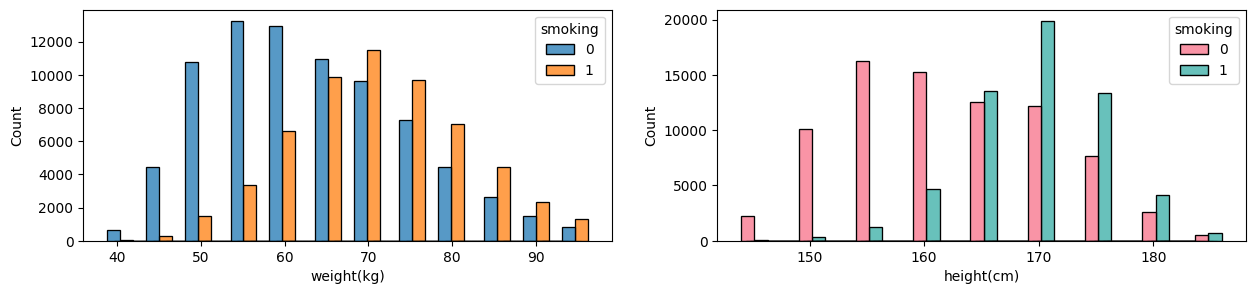

In [121]:
plt.figure(figsize=(15,3))
plt.subplot(121)
sns.histplot(x=train_data['weight(kg)'], hue=train_data.smoking, stat='count', multiple='dodge', shrink=4)
plt.subplot(122)
sns.histplot(x=train_data['height(cm)'], hue=train_data.smoking, stat='count', multiple='dodge', shrink=6, palette='husl')

It seems that most of smokers in our dataset has a weight between 65-85 kg. While the most smokers are between 165-175 cm tall.

<Axes: xlabel='hemoglobin', ylabel='Count'>

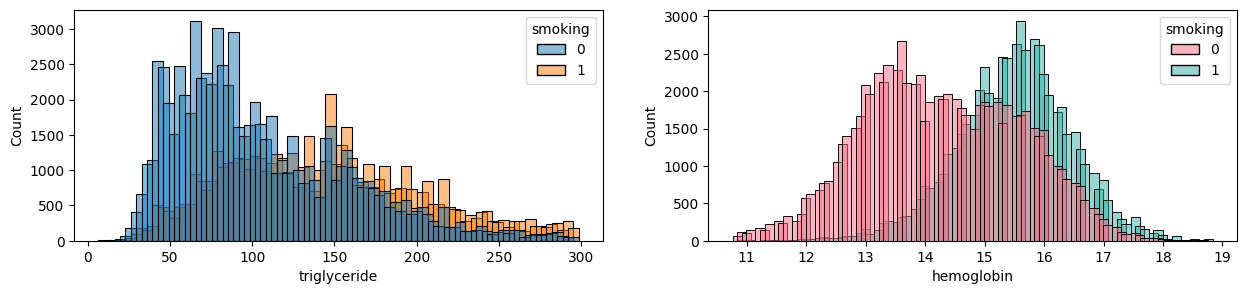

In [122]:
plt.figure(figsize=(15,3))
plt.subplot(121)
sns.histplot(x=train_data['triglyceride'], hue=train_data.smoking, stat='count', multiple='layer', shrink=2)
plt.subplot(122)
sns.histplot(x=train_data['hemoglobin'], hue=train_data.smoking, stat='count', multiple='layer', shrink=2, palette='husl')

Here we have plotted the most correlated features. Smoking status can be recognized when triglyceride are about 100-200, while hemoglobin level set much more difference: the range value between 15-17 are smokers; the non-smokers space between a bigger range: 13-17

## Feature engineering

### Features extraction
We also decide to create new features from our data, in order to improve our model and better represent our data

#### BMI

Text(0.5, 1.0, 'Histogram of BMI')

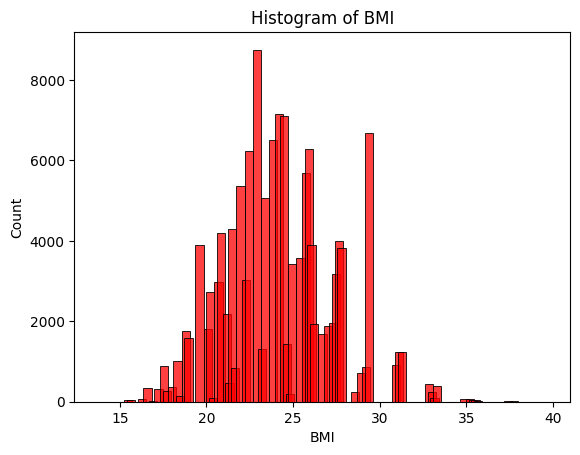

In [123]:
train_data['BMI'] = train_data['weight(kg)']/(train_data['height(cm)']/100)**2 # application of BMI formula
sns.histplot(train_data['BMI'],color='red', shrink=3)
plt.title("Histogram of BMI")

Text(0.5, 1.0, 'Comparison of BMI between smokers and non-smokers')

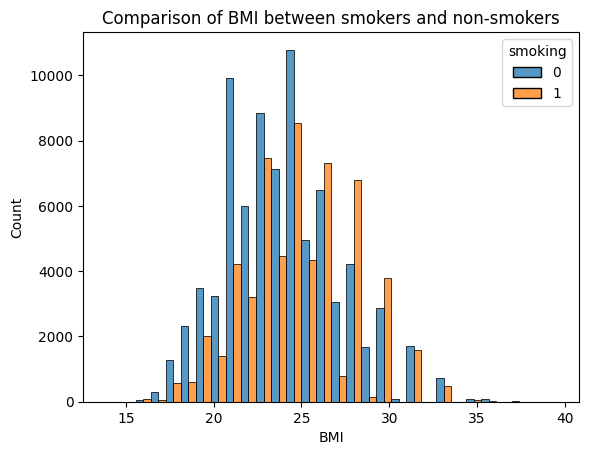

In [124]:
sns.histplot(x=train_data['BMI'], hue=train_data.smoking, stat='count', multiple='dodge', shrink=1, bins=30)
plt.title("Comparison of BMI between smokers and non-smokers")

We see that the feature extracted does not distribute well as like as the correlated feature as before (that's could make the model less precise)

### Features selection

In [125]:
# Features to ignore, since less correlated with 'smoking'
IGNORE_FEATURES={'BMI'}
IGNORE_FEATURES = IGNORE_FEATURES.union(to_ignore)
IGNORE_FEATURES.remove('id')

## Data preprocessing

In [126]:
# rename relaxation column to diastolic in train_data
train_data.rename(columns={'relaxation':'diastolic'}, inplace=True)

### Normalization

In [127]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
normalizer=MinMaxScaler((0,1))

## Machine Learning

In [128]:
ID_COLUMN='id'
Y_COLUMN='smoking'

We split our data in training, validation and test

In [129]:
X_IGNORE={ID_COLUMN,Y_COLUMN,*IGNORE_FEATURES}
X_COLUMNS=[column for column in train_data.columns if column not in X_IGNORE]
X_CATEGORICAL = list(set(CATEGORICAL_FEATURES) & set(X_COLUMNS))

X = train_data[X_COLUMNS].copy()
y = train_data[Y_COLUMN].copy()

X.head()

,age,height(cm),weight(kg),waist(cm),diastolic,triglyceride,hemoglobin,serum creatinine,Gtp,dental caries
1,70,165,65,89.0,83,55,16.2,1.1,37,1
2,20,170,75,81.0,75,197,17.4,0.8,53,0
3,35,180,95,105.0,88,203,15.9,1.0,30,1
4,30,165,60,80.5,76,87,15.4,0.8,17,0
6,45,160,55,69.0,88,153,13.0,0.7,16,0


In [130]:
from sklearn.model_selection import train_test_split
Xl, Xt, yl, yt = train_test_split(X,y, test_size = .1, random_state=SEED)

In [131]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score

# Auxiliary function for applying the model passed by argument
def test_model(model, norm=True):
    if norm:
        pipe = Pipeline([
            ('normalizer', normalizer),
            ('model', model)
        ])
    else:
        pipe = Pipeline([
            ('model', model)
        ]) 
        
    pipe.fit(Xl,yl)
    yp = pipe.predict(Xt)
    print('Accuracy score: ', accuracy := accuracy_score(yt,yp)) # how much percentage the model has done good
    print('ROC AUC score: ', roc := roc_auc_score(yt,yp))
    print('\n')
    return (pipe, [accuracy, roc])

Now we try different models and look to their accuracy, in order to decide which perform better.
<br><br>
We also try to tune different hyperparameters to the model, the ones that optimize the outcome score.

### Choosing the model
Now we will compare the precisions of different models, without any tuning, to see how they behave on our data.

In [132]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier # doesn't need normalized data
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

print("Model: RidgeClassifier")
_, ridgescore = test_model(RidgeClassifierCV())
print("Model: RandomForestClassifier")
_, forestscore = test_model(RandomForestClassifier(n_jobs=-1, random_state=SEED), norm=False)
print("Model: GradientBoostingClassifier")
pipe, gradscore = test_model(GradientBoostingClassifier(random_state=SEED), norm=False)
print("Model: HistGradientBoostingClassifier")
pipe, histscore = test_model(HistGradientBoostingClassifier(random_state=SEED, categorical_features=X_CATEGORICAL), norm=False)

Model: RidgeClassifier
Accuracy score:  0.7429654468581426
ROC AUC score:  0.7392874216350845


Model: RandomForestClassifier


Accuracy score:  0.7539728823443651
ROC AUC score:  0.7552496444629414


Model: HistGradientBoostingClassifier
Accuracy score:  0.7635223793555912
ROC AUC score:  0.7668357742924268




Text(0.5, 1.0, 'Comparison of classification models')

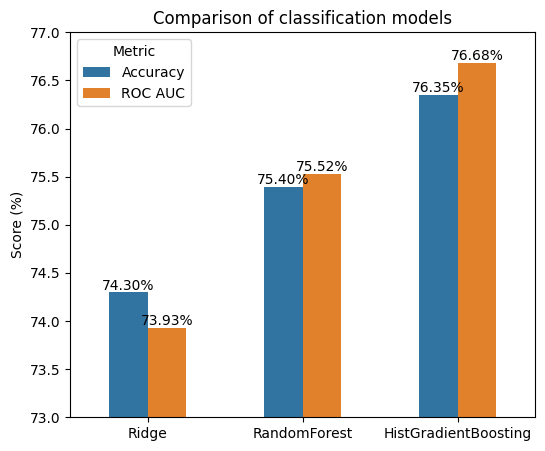

In [133]:
scores = {'Ridge': ridgescore, 'RandomForest': forestscore, 'GradientBoosting': gradscore, 'HistGradientBoosting': histscore}
indexes = {'Accuracy': 0, 'ROC AUC': 1}
array = [[name, score[index]*100, title] for name, score in scores.items() for title, index in indexes.items()]
tmp = pd.DataFrame(array, columns=['Model', 'Score', 'Metric'])

plt.figure(figsize=(8,5))
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=tmp, width=0.5)

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f%%')

plt.ylim((73,77))
plt.xlabel("")
plt.ylabel("Score (%)")
plt.title("Comparison of classification models")

#### Score definitions
- **Accuracy**: This metric represent the precision of the model, looking to how much far the prediction has been made from the real value.

- **ROC AUC (Receiver Operating Characteristic Area Under the Curve)**: This metric is used to evaluate the performance of binary classification models. It is the area under the ROC curve, which plots the true positive rate against the false positive rate. A higher ROC AUC score indicates that the model is better at distinguishing between positive and negative cases.

### Model Tuning

#### Hist Gradient Boosting

In [134]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
grid = {
    'max_iter': [250,300,350],
    'early_stopping': [True, False],
    'max_depth': [5, 7, None],
    'validation_fraction': [0.0001, 0.001, 0.01]
}

# Create the GridSearchCV object
MS = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=SEED, categorical_features=X_CATEGORICAL),
    param_grid=grid,
    scoring='roc_auc'
)

# Fit the model with the training data
H = MS.fit(Xl, yl)

In [135]:
print('max_iter:', H.best_params_['max_iter'])
print('early_stopping:', H.best_params_['early_stopping'])
print('max_depth:', H.best_params_['max_depth'])
print('validation_fraction:', H.best_params_['validation_fraction'])

max_iter: 300
early_stopping: False
max_depth: 5
validation_fraction: 0.0001


In [136]:
pipe, _ = test_model(HistGradientBoostingClassifier(max_iter=H.best_params_['max_iter'], early_stopping=H.best_params_['early_stopping'], max_depth=H.best_params_['max_depth'], validation_fraction=H.best_params_['validation_fraction'], random_state=SEED, categorical_features = X_CATEGORICAL), norm=False)

Accuracy score:  0.7648345239830879
ROC AUC score:  0.7683105274717081




#### Model Behaviors

Now we try to modify furthermore our data, in particular operating on the most correlated features (and so more sensible) and see how our chosen model behave

We remove height and weight and add BMI (relative to them)

In [137]:
X = X.drop(columns = ['weight(kg)', 'height(cm)'], axis=1) # less correlated column with smoke, highly correlated with others
X['BMI'] = train_data['BMI']

In [138]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
X[X_CATEGORICAL] = ordinal_encoder.fit_transform(X[X_CATEGORICAL]) # since we have created class categories

Xl, Xt, yl, yt = train_test_split(X,y, test_size = .1, random_state=SEED)

new tuning after BMI

In [139]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
grid = {
    'max_iter': [250,300,350],
    'early_stopping': [True, False],
    'max_depth': [5, 7, None],
    'validation_fraction': [0.0001, 0.001, 0.01]
}

# Create the GridSearchCV object
MS = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=SEED, categorical_features=X_CATEGORICAL),
    param_grid=grid,
    scoring='roc_auc'
)

# Fit the model with the training data
H = MS.fit(Xl, yl)

In [140]:
print('max_iter:', H.best_params_['max_iter'])
print('early_stopping:', H.best_params_['early_stopping'])
print('max_depth:', H.best_params_['max_depth'])
print('validation_fraction:', H.best_params_['validation_fraction'])

max_iter: 350
early_stopping: False
max_depth: 5
validation_fraction: 0.0001


In [141]:
pipe, _ = test_model(HistGradientBoostingClassifier(max_iter=H.best_params_['max_iter'], early_stopping=H.best_params_['early_stopping'], max_depth=H.best_params_['max_depth'], validation_fraction=H.best_params_['validation_fraction'], random_state=SEED, categorical_features = X_CATEGORICAL), norm=False)

Accuracy score:  0.7645429362880887
ROC AUC score:  0.7665098466465278




Then we operate on hemoglobin, another highly correlated feature
<br> - referments taken from this article: https://www.verywellhealth.com/hemoglobin-level-5211543

In [142]:
hemos = ["Low", "Normal", "High"]
hemoglobin = pd.Series(hemos, dtype = "category")
X["hemoglobin_lvl"] = hemoglobin

X.loc[(X["age"] <= 18) & (X["hemoglobin"] < 11.5), "hemoglobin_lvl"] = hemoglobin[0]
X.loc[(X["age"] <= 18) & (X["hemoglobin"] > 11.5) & (X["hemoglobin"] < 16.3), "hemoglobin_lvl"] = hemoglobin[1]
X.loc[(X["age"] <= 18) & (X["hemoglobin"] > 16.3), "hemoglobin_lvl"] = hemoglobin[2]
X.loc[(X["age"] > 18) & (X["hemoglobin"] < 10.4), "hemoglobin_lvl"] = hemoglobin[0]
X.loc[(X["age"] > 18) & (X["hemoglobin"] > 10.4) & (X["hemoglobin"] < 17.1), "hemoglobin_lvl"] = hemoglobin[1]
X.loc[(X["age"] > 18) & (X["hemoglobin"] > 17.1), "hemoglobin_lvl"] = hemoglobin[2]

X_CATEGORICAL.append('hemoglobin_lvl')
X = X.drop(columns = ['hemoglobin'], axis=1)
X.head()

,age,waist(cm),diastolic,triglyceride,serum creatinine,Gtp,dental caries,BMI,hemoglobin_lvl
1,70,89.0,83,55,1.1,37,1.0,23.875115,Normal
2,20,81.0,75,197,0.8,53,0.0,25.951557,High
3,35,105.0,88,203,1.0,30,1.0,29.320988,Normal
4,30,80.5,76,87,0.8,17,0.0,22.038567,Normal
6,45,69.0,88,153,0.7,16,0.0,21.484375,Normal


In [143]:
print(X_CATEGORICAL)
print(X_COLUMNS)

['dental caries', 'hemoglobin_lvl']
['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'diastolic', 'triglyceride', 'hemoglobin', 'serum creatinine', 'Gtp', 'dental caries']


In [144]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
X[X_CATEGORICAL] = ordinal_encoder.fit_transform(X[X_CATEGORICAL]) # since we have created class categories

Xl, Xt, yl, yt = train_test_split(X,y, test_size = .1, random_state=SEED)

new tuning after hemoglobin_lvl

In [145]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
grid = {
    'max_iter': [250,300,350],
    'early_stopping': [True, False],
    'max_depth': [5, 7, None],
    'validation_fraction': [0.0001, 0.001, 0.01]
}

# Create the GridSearchCV object
MS = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=SEED, categorical_features=X_CATEGORICAL),
    param_grid=grid,
    scoring='roc_auc'
)

# Fit the model with the training data
H = MS.fit(Xl, yl)

In [146]:
print('max_iter:', H.best_params_['max_iter'])
print('early_stopping:', H.best_params_['early_stopping'])
print('max_depth:', H.best_params_['max_depth'])
print('validation_fraction:', H.best_params_['validation_fraction'])

max_iter: 350
early_stopping: False
max_depth: 5
validation_fraction: 0.0001


In [147]:
pipe, _ = test_model(HistGradientBoostingClassifier(max_iter=H.best_params_['max_iter'], early_stopping=H.best_params_['early_stopping'], max_depth=H.best_params_['max_depth'], validation_fraction=H.best_params_['validation_fraction'], random_state=SEED, categorical_features = X_CATEGORICAL), norm=False)

Accuracy score:  0.7568887592943577
ROC AUC score:  0.7568482575814472




Finally we operate on a less correlated feature, the diastolic blood pressure, and see how to model react

In [148]:
blood_rates = ["Normal", "Elevated", "High", "Very High"]
blood_pressure = pd.Series(blood_rates, dtype = "category")
X["diastolic_pressure"] = blood_pressure

X.loc[(X["diastolic"] < 80), "diastolic_pressure"] = blood_pressure[0]
X.loc[(X["diastolic"] >= 80) & (X["diastolic"] <= 89), "diastolic_pressure"] = blood_pressure[1]
X.loc[(X["diastolic"] >= 90) & (X["diastolic"] <= 99), "diastolic_pressure"] = blood_pressure[2]
X.loc[(X["diastolic"] >= 100), "diastolic_pressure"] = blood_pressure[3]

X_CATEGORICAL.append('diastolic_pressure')
X = X.drop(columns = ['diastolic'], axis=1)
X.head()

,age,waist(cm),triglyceride,serum creatinine,Gtp,dental caries,BMI,hemoglobin_lvl,diastolic_pressure
1,70,89.0,55,1.1,37,1.0,23.875115,1.0,Elevated
2,20,81.0,197,0.8,53,0.0,25.951557,0.0,Normal
3,35,105.0,203,1.0,30,1.0,29.320988,1.0,Elevated
4,30,80.5,87,0.8,17,0.0,22.038567,1.0,Normal
6,45,69.0,153,0.7,16,0.0,21.484375,1.0,Elevated


In [149]:
print(X_CATEGORICAL)
print(X_COLUMNS)

['dental caries', 'hemoglobin_lvl', 'diastolic_pressure']
['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'diastolic', 'triglyceride', 'hemoglobin', 'serum creatinine', 'Gtp', 'dental caries']


In [150]:
X.head()

,age,waist(cm),triglyceride,serum creatinine,Gtp,dental caries,BMI,hemoglobin_lvl,diastolic_pressure
1,70,89.0,55,1.1,37,1.0,23.875115,1.0,Elevated
2,20,81.0,197,0.8,53,0.0,25.951557,0.0,Normal
3,35,105.0,203,1.0,30,1.0,29.320988,1.0,Elevated
4,30,80.5,87,0.8,17,0.0,22.038567,1.0,Normal
6,45,69.0,153,0.7,16,0.0,21.484375,1.0,Elevated


In [151]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
X[X_CATEGORICAL] = ordinal_encoder.fit_transform(X[X_CATEGORICAL]) # since we have created class categories

Xl, Xt, yl, yt = train_test_split(X,y, test_size = .1, random_state=SEED)

In [152]:
X.head()

,age,waist(cm),triglyceride,serum creatinine,Gtp,dental caries,BMI,hemoglobin_lvl,diastolic_pressure
1,70,89.0,55,1.1,37,1.0,23.875115,1.0,0.0
2,20,81.0,197,0.8,53,0.0,25.951557,0.0,2.0
3,35,105.0,203,1.0,30,1.0,29.320988,1.0,0.0
4,30,80.5,87,0.8,17,0.0,22.038567,1.0,2.0
6,45,69.0,153,0.7,16,0.0,21.484375,1.0,0.0


new (final) tuning after diastolic

In [153]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
grid = {
    'max_iter': [250,300,350],
    'early_stopping': [True, False],
    'max_depth': [5, 7, None],
    'validation_fraction': [0.0001, 0.001, 0.01]
}

# Create the GridSearchCV object
MS = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=SEED, categorical_features=X_CATEGORICAL),
    param_grid=grid,
    scoring='roc_auc'
)

# Fit the model with the training data
H = MS.fit(Xl, yl)

In [154]:
print('max_iter:', H.best_params_['max_iter'])
print('early_stopping:', H.best_params_['early_stopping'])
print('max_depth:', H.best_params_['max_depth'])
print('validation_fraction:', H.best_params_['validation_fraction'])

max_iter: 350
early_stopping: False
max_depth: 5
validation_fraction: 0.0001


In [155]:
pipe, _ = test_model(HistGradientBoostingClassifier(max_iter=H.best_params_['max_iter'], early_stopping=H.best_params_['early_stopping'], max_depth=H.best_params_['max_depth'], validation_fraction=H.best_params_['validation_fraction'], random_state=SEED, categorical_features = X_CATEGORICAL), norm=False)

Accuracy score:  0.7567429654468582
ROC AUC score:  0.7567483169314569




Text(50.722222222222214, 0.5, 'True')

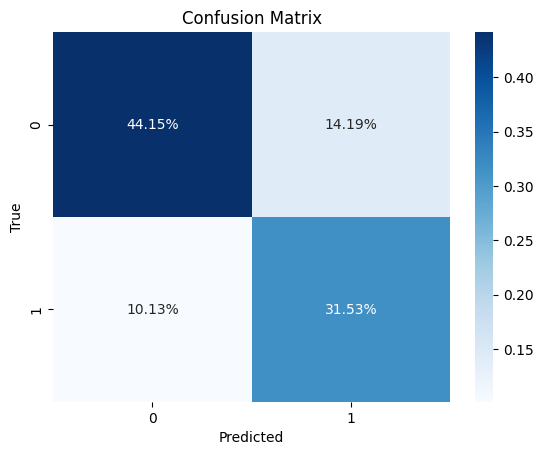

In [157]:
# plot the confusion matrix of the model
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(yt, pipe.predict(Xt))/len(yt), annot=True, fmt='.2%', cmap='Blues') # diagonal represent accuracy
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

## Kaggle submission & CSV

In [ ]:
model.fit(X,y)
test_data = pd.read_csv('test.csv')
X_test=test_data[X_COLUMNS].copy()
y_test=model.predict(X_test)
result=pd.merge(test_data[ID_COLUMN], pd.Series(y_test,name=Y_COLUMN), left_index=True, right_index=True)
result.to_csv('submission.csv',index=False)

"model.fit(X,y)\ntest_data = pd.read_csv('test.csv')\nX_test=test_data[X_COLUMNS].copy()\ny_test=model.predict(X_test)\nresult=pd.merge(test_data[ID_COLUMN], pd.Series(y_test,name=Y_COLUMN), left_index=True, right_index=True)\nresult.to_csv('submission.csv',index=False)"

In [ ]:
!kaggle competitions submit -c $KAGGLE_COMPETITION_NAME -f submission.csv -m ''

'!kaggle competitions submit -c $KAGGLE_COMPETITION_NAME -f submission.csv -m '

In [ ]:
!kaggle competitions submissions -c $KAGGLE_COMPETITION_NAME

'!kaggle competitions submissions -c $KAGGLE_COMPETITION_NAME'